In [1]:
import optical_gating_analysis as OG
import matplotlib.pyplot as plt
import numpy as np
import j_py_sad_correlation as jps

from scipy.signal import find_peaks


In [2]:
data_src = r"E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.38.02 vid pre-caffeine 3\Allied Vision Technologies GS650 0001f61c\*tif"
ref_src = r"E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.38.02 vid pre-caffeine 3\ref-frames-2024-04-05-17.37.43\*tif"
ref_period = 158.758804

In [3]:
oog = OG.BasicOpticalGating()#.default()
oog.sequence_manager.set_source(data_src)
oog.sequence_manager.set_reference_sequence(ref_src)
oog.sequence_manager.reference_period = ref_period
oog.settings["pi_space"] = True
oog.settings["include_reference_frames"] = True
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.44.48 vid post-caffeine 0.01mgl\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024\2024-04-05 17.46.44 vid normal fit post-caffeine\ref-frames-2024-04-05-17.46.39\*tif
Getting SADs
Getting phases


In [4]:
data = OG.SequenceManager.load_tif(oog.sequence_manager.sequence_src)

In [5]:
diffs = np.sum(np.abs(np.diff(data.astype(np.int16), axis=0)), axis = (1,2))

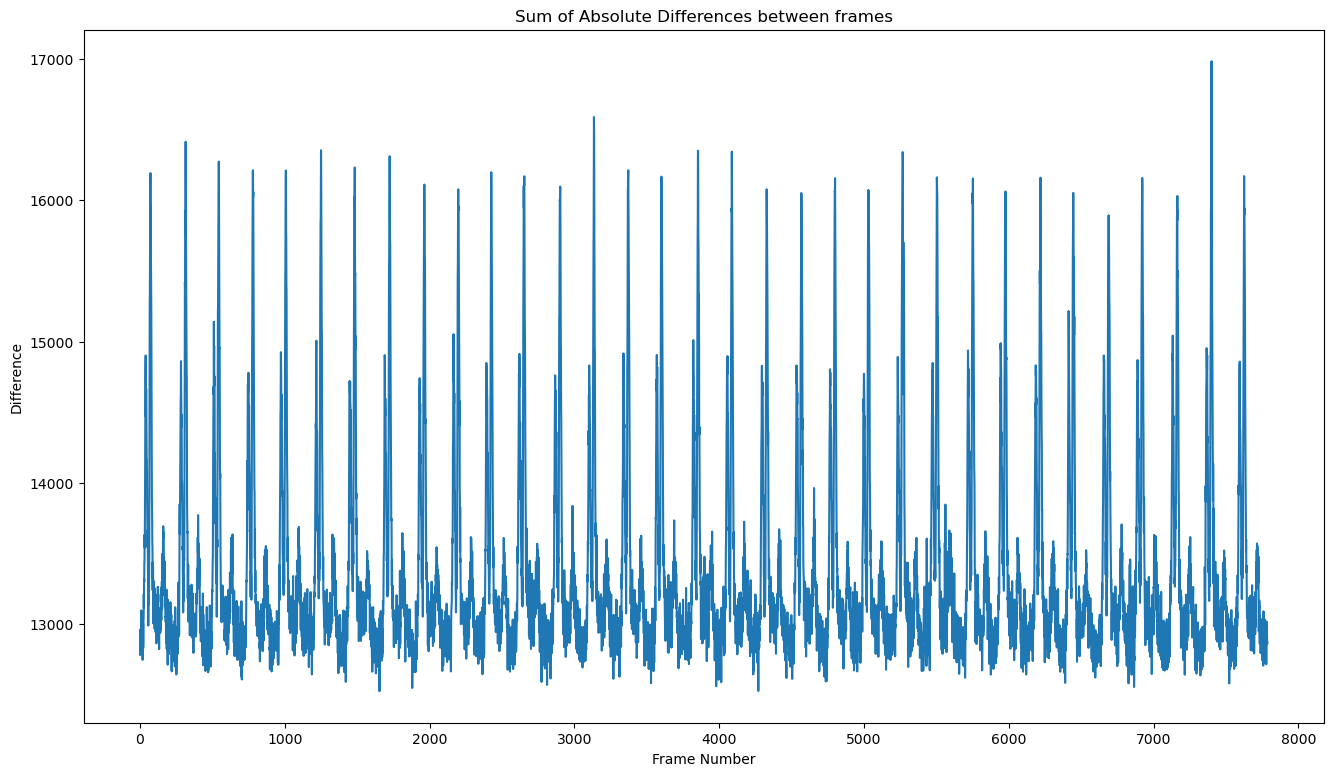

In [6]:
plt.figure(figsize = (16,9))
plt.title("Sum of Absolute Differences between frames")
plt.plot(diffs)
plt.xlabel("Frame Number")
plt.ylabel("Difference")
plt.show()

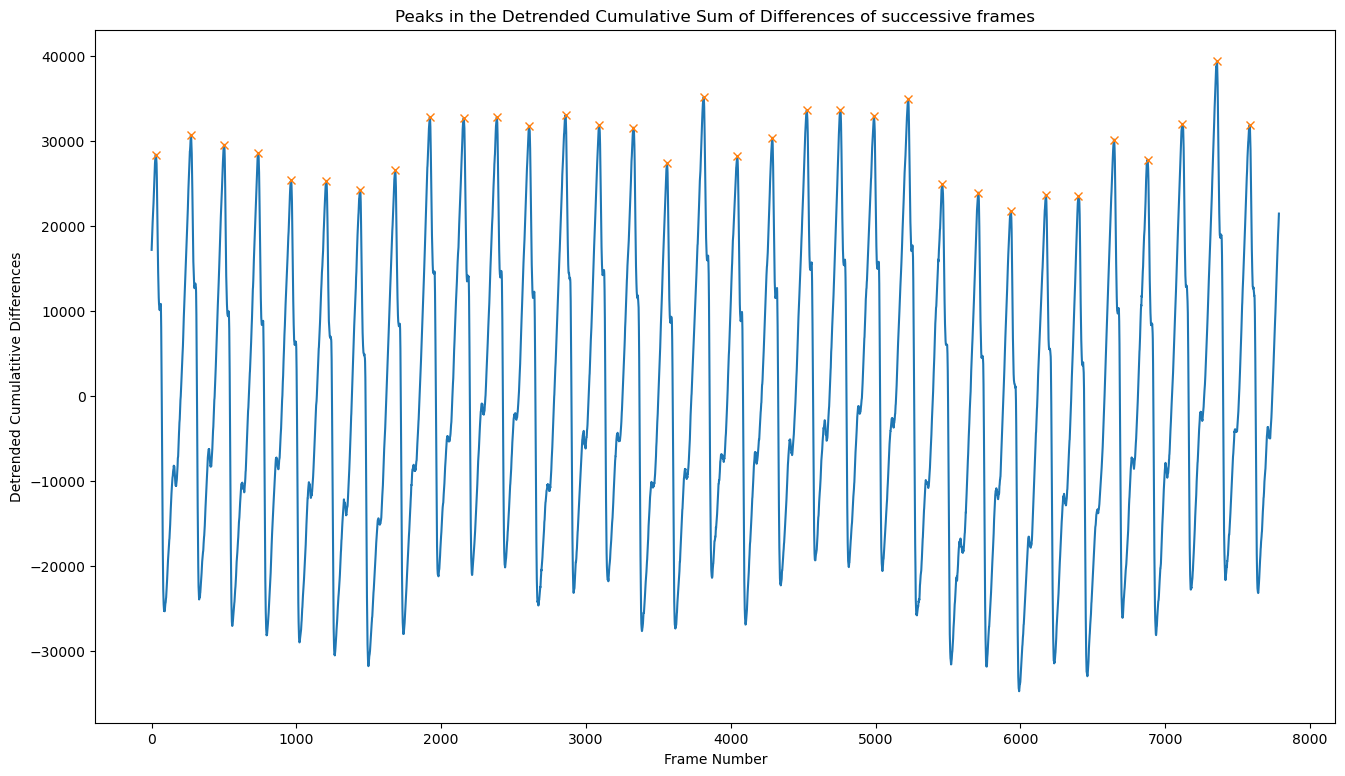

In [17]:
diffs_cumsum = np.cumsum(diffs)

# Detrend using linear fit
x = np.arange(0, len(diffs_cumsum))
fit = np.polyfit(x, diffs_cumsum, 1)

diffs_cumsum_detrended = diffs_cumsum - np.polyval(fit, x)

# Find peaks
peaks, _ = find_peaks(-diffs_cumsum_detrended, height=18000, distance=40)
plt.figure(figsize = (16,9))
plt.plot(x, -diffs_cumsum_detrended)
plt.plot(x[peaks], -diffs_cumsum_detrended[peaks], "x")
plt.title("Peaks in the Detrended Cumulative Sum of Differences of successive frames")
plt.xlabel("Frame Number")
plt.ylabel("Detrended Cumulatitive Differences")
plt.show()


# Get subframes
subframes = []
for i in range(len(peaks) - 1):
    subframes.append(peaks[i] + OG.v_fitting(diffs_cumsum_detrended[peaks[i] - 1], diffs_cumsum_detrended[peaks[i]], diffs_cumsum_detrended[peaks[i] + 1])[0])


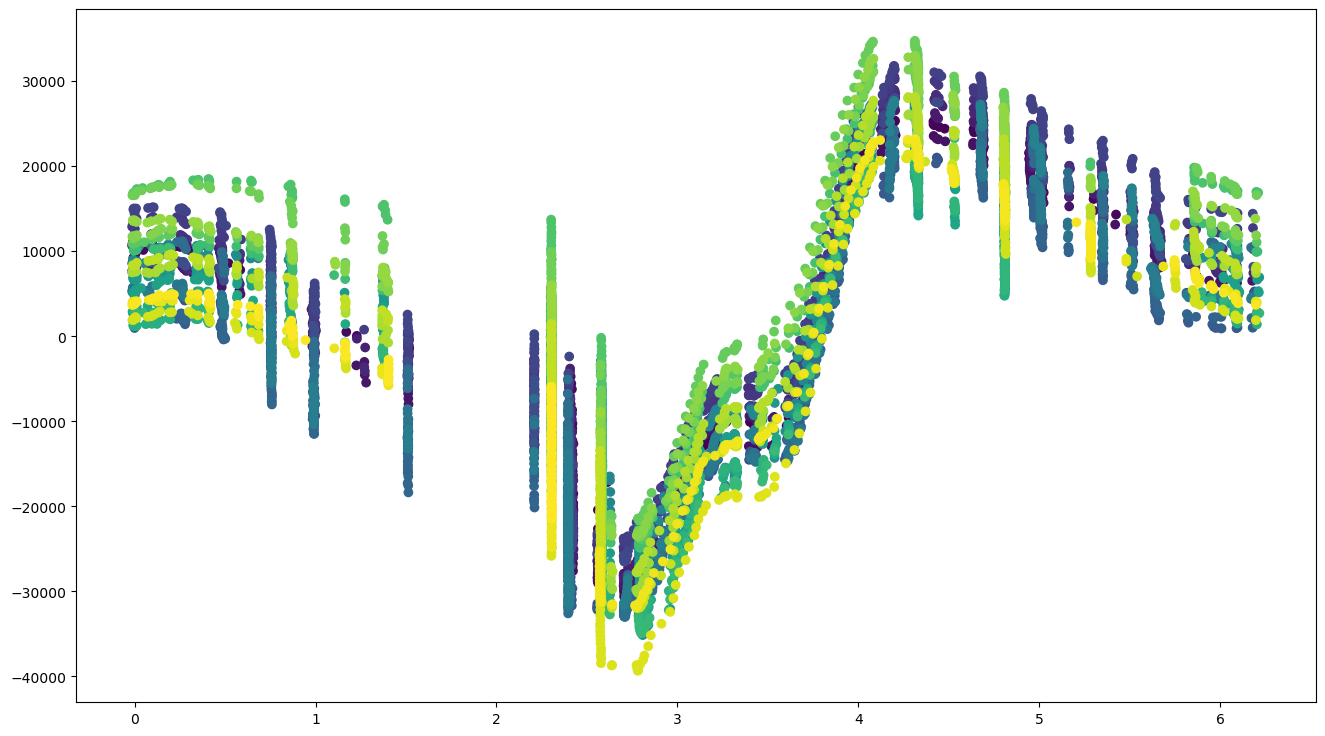

In [18]:
plt.figure(figsize = (16,9))
plt.scatter(oog.phases, diffs_cumsum_detrended, c = range(len(oog.phases)))
plt.show()

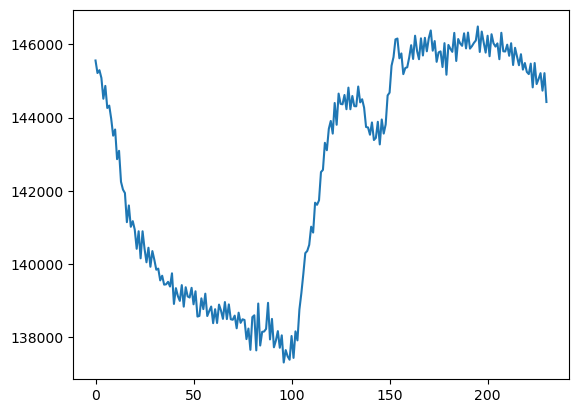

In [19]:
plt.plot(oog.sads[0])
plt.show()

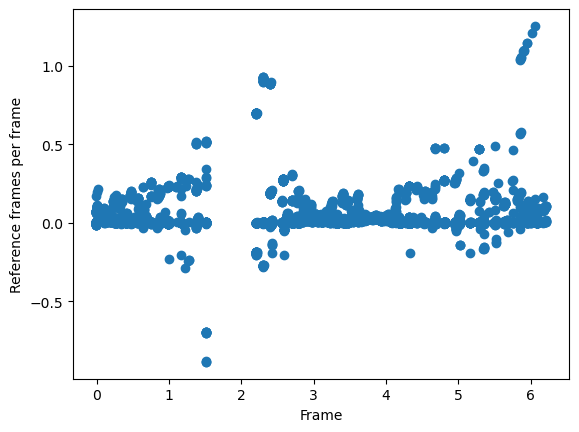

In [20]:
plt.scatter(oog.phases[1::], oog.delta_phases)
plt.xlabel("Frame")
plt.ylabel("Reference frames per frame")
plt.show()

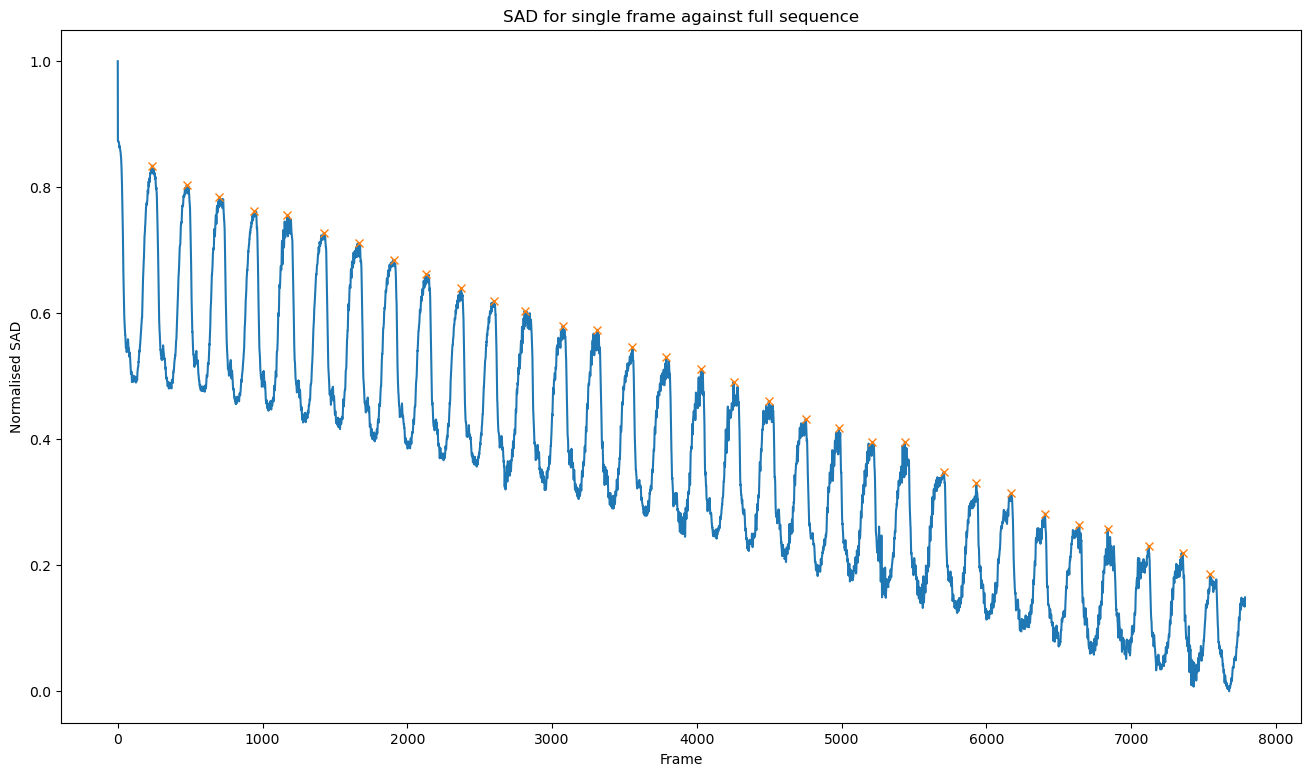

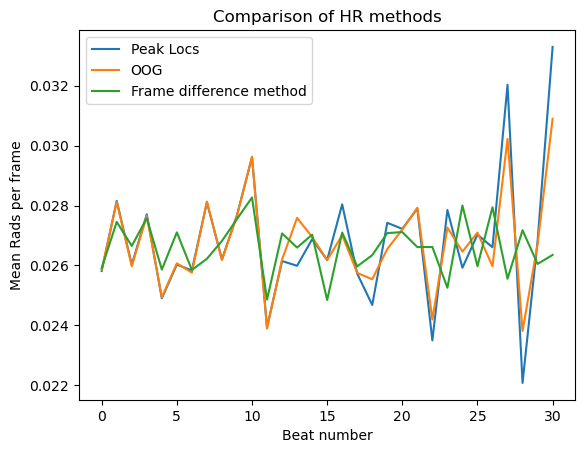

In [21]:
sad = -jps.sad_with_references(data[0], data)

# Detrend SADs using linear fit
"""x = np.arange(0, len(sad))
fit = np.polyfit(x, sad, 1)

sad -= np.polyval(fit, x)"""

# Normalise SAD
sad -= np.min(sad)
sad /= np.max(sad)

# Plot peaks
plt.figure(figsize = (16,9))
plt.plot(sad)
peaks, _ = find_peaks(sad, height=0.1, distance = 20, prominence = 0.1)
plt.plot(peaks, sad[peaks], "x")
plt.title("SAD for single frame against full sequence")
plt.xlabel("Frame")
plt.ylabel("Normalised SAD")
plt.show()

# Find location of peaks
peak_locs = []
for peak in peaks:
    peak_subframe = OG.v_fitting(-sad[peak - 1], -sad[peak], -sad[peak + 1])
    peak_loc = peak + peak_subframe[0]
    peak_locs.append(peak_loc)

delta_phases_pl = 2 * np.pi / np.diff(peak_locs)

# Get mean delta-phases using uwnrapped phases at these locations
delta_phases_up = []
for i in range(0, len(peaks) - 1):
    delta_phases_up.append(oog.unwrapped_phases[peaks[i + 1]] - oog.unwrapped_phases[peaks[i]])

# Get mean delta-phases at these locations
delta_phases = []
for i in range(0, len(peaks) - 1):
    delta_phases.append(np.mean(oog.delta_phases[peaks[i]:peaks[i + 1]]))

# Plot
plt.plot(delta_phases_pl, label = "Peak Locs")
plt.plot(delta_phases, label = "OOG")
plt.plot(2 * np.pi / np.diff(subframes), label = "Frame difference method")
#plt.plot(delta_phases_up, label = "OOG unwrapped")
#for i in range(len(peak_locs) - 1):
#    plt.axvline(i, color = "black", linestyle = "--", c = "black", alpha = 0.5, lw = 1)
plt.legend()
plt.title("Comparison of HR methods")
plt.xlabel("Beat number")
plt.ylabel("Mean Rads per frame")
plt.show()

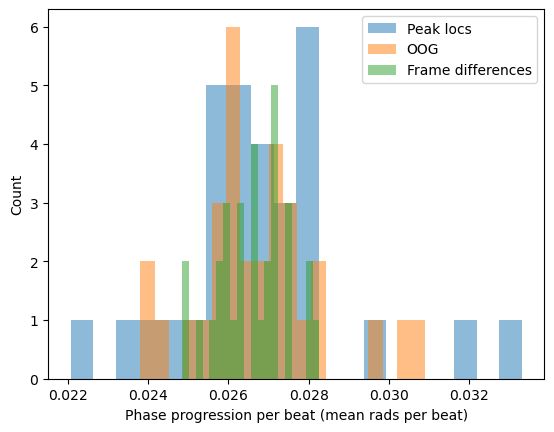

In [22]:
#plt.hist([delta_phases_pl, 2 * np.pi / np.diff(subframes)], bins = 5, label = ["Peak Locs", "OOG", "Frame differences"], alpha = 0.5)
plt.hist(delta_phases_pl, bins = 20, label = "Peak locs", alpha = 0.5)
plt.hist(delta_phases, bins = 20, label = "OOG", alpha = 0.5)
plt.hist(2 * np.pi / np.diff(subframes), bins = 20, label = "Frame differences", alpha = 0.5)
plt.xlabel("Phase progression per beat (mean rads per beat)")
plt.ylabel("Count")
plt.legend()
plt.show()

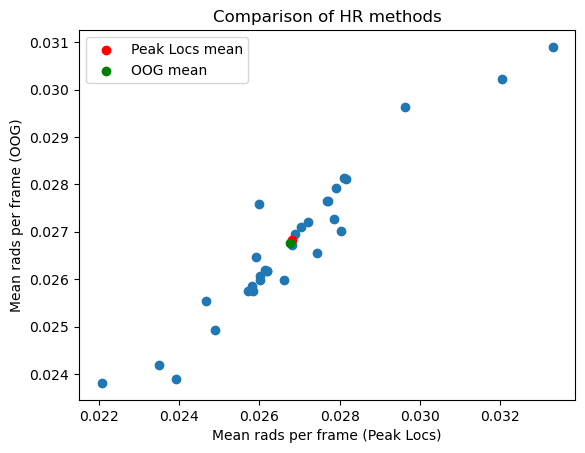

In [23]:
plt.title("Comparison of HR methods")
plt.scatter(delta_phases_pl, delta_phases)
plt.xlabel("Mean rads per frame (Peak Locs)")
plt.ylabel("Mean rads per frame (OOG)")
# Plot midpoing of peak_locs
plt.scatter(np.mean(delta_phases_pl), np.mean(delta_phases_pl), color = "red", label = "Peak Locs mean")
plt.scatter(np.mean(delta_phases), np.mean(delta_phases), color = "green", label = "OOG mean")
plt.legend()
plt.show()

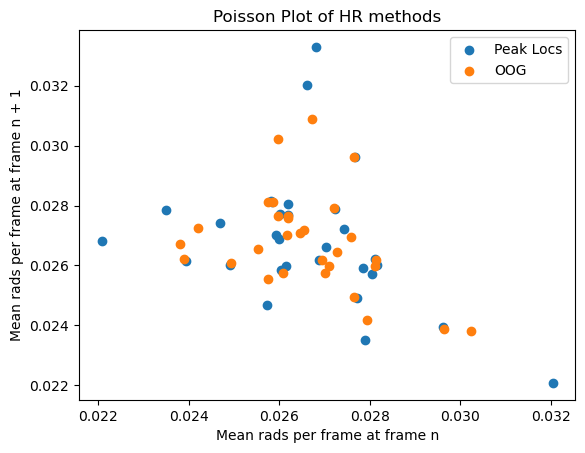

In [24]:
plt.title("Poisson Plot of HR methods")
plt.scatter(delta_phases_pl[0:-1], delta_phases_pl[1::], label = "Peak Locs")
plt.scatter(delta_phases[0:-1], delta_phases[1::], label = "OOG")
plt.xlabel("Mean rads per frame at frame n")
plt.ylabel("Mean rads per frame at frame n + 1")
plt.legend()
plt.show()

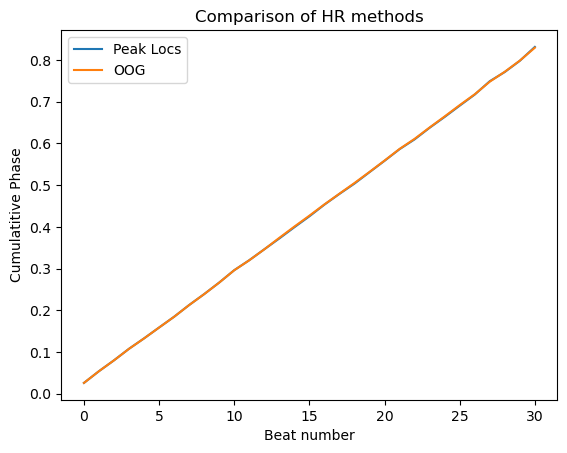

OOG:		0.8313218363561005
Peaks:		0.8294108221304137


In [15]:
plt.plot(np.cumsum(delta_phases_pl), label = "Peak Locs")
plt.plot(np.cumsum(delta_phases), label = "OOG")
plt.legend()
plt.title("Comparison of HR methods")
plt.xlabel("Beat number")
plt.ylabel("Cumulatitive Phase")
plt.show()
print(f"OOG:\t\t{np.max(np.cumsum(delta_phases_pl))}")
print(f"Peaks:\t\t{np.max(np.cumsum(delta_phases))}")

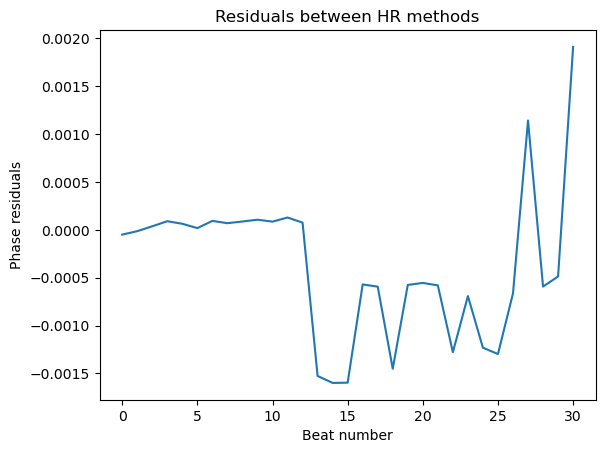

In [25]:
plt.plot(np.cumsum(delta_phases_pl) - np.cumsum(delta_phases))
plt.title("Residuals between HR methods")
plt.xlabel("Beat number")
plt.ylabel("Phase residuals")
plt.show()